In [1]:
from multicamera_acquisition.paths import DATA_DIR
from multicamera_acquisition.acquisition import AcquisitionLoop
from multicamera_acquisition.interfaces.camera_uvc import UVCCamera as Camera
from multicamera_acquisition.writer import FFMPEG_Writer as Writer
from multicamera_acquisition.video_utils import count_frames
import time
from datetime import datetime
import multiprocessing as mp
from os.path import join
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

/Users/jonahpearl/Documents/PiN/Datta_lab/Local_code/multicamera_acquisition/multicamera_acquisition/interfaces/camera_azure.py:18: UserWarning: pyk4a not installed.  Azure cameras will not be available.
  warnings.warn("pyk4a not installed.  Azure cameras will not be available.")


In [2]:
save_path = "/Users/jonahpearl/Documents/PiN/Datta_lab/tmp/"
save_location = join(save_path, 'facecam_tests')
fps = 210
duration = 10 * 1000 # msec

## Working config setup

In [3]:
camera_config = Camera.default_camera_config().copy()
camera_config["name"] = "test_camera"
camera_config["fps"] = fps
file_name = f'{camera_config["name"]}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'

In [4]:
write_queue = mp.Queue()
writer_config = Writer.default_writer_config(fps).copy()
writer_config["camera_name"] = camera_config["name"]
writer = Writer(write_queue, 
                video_file_name=join(save_location, f"{file_name}.mp4"),
                metadata_file_name=join(save_location, f"{file_name}.csv"),
                config=writer_config, logging_level=10)

In [5]:
acq_config = AcquisitionLoop.default_acq_loop_config().copy()
acq_config["max_frames_to_acquire"] = int(fps * duration / 1000)
acq_loop = AcquisitionLoop(write_queue=write_queue,
                           display_queue=None,
                           camera_device_index=None,
                           camera_config=camera_config,
                           acq_loop_config=acq_config,
                           fps=fps)

## Test not working config

In [3]:
from multicamera_acquisition.config import (
    load_config,
)

In [4]:
config_filepath = R'/Users/jonahpearl/Documents/PiN/Datta_lab/Local_code/multicamera_acquisition/notebooks/face_cam/facecam_config.yaml'
config = load_config(config_filepath)
camera_config = config["cameras"]["face_cam"]
camera_config["display"]["display_frames"] = False
camera_config["writer"]["gpu"] = None

In [5]:
file_name = f'{camera_config["name"]}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
write_queue = mp.Queue()
writer = Writer(write_queue, 
                video_file_name=join(save_location, f"{file_name}.mp4"),
                metadata_file_name=join(save_location, f"{file_name}.csv"),
                config=config["cameras"]["face_cam"]["writer"])

In [6]:
acq_loop = AcquisitionLoop(write_queue=write_queue,
                           display_queue=None,
                           camera_device_index=None,
                           camera_config=camera_config,
                           acq_loop_config=config["acq_loop"],
                           fps=fps)

## Run

In [7]:
# start recording
writer.start()

acq_loop.start()
acq_loop.await_process.wait()
acq_loop.await_main_thread.set()
acq_loop.await_process.wait()

time.sleep(duration/1000)
acq_loop.stop()

acq_loop.join(timeout=60)
writer.join(timeout=60)

Writing frame 0...
Writing frame 1...
Writing frame 2...
Writing frame 3...
Writing frame 4...
Writing frame 5...
Writing frame 6...
Writing frame 7...
Writing frame 8...
Writing frame 9...
Writing frame 10...
Writing frame 11...
Writing frame 12...
Writing frame 13...
Writing frame 14...
Writing frame 15...
Writing frame 16...
Writing frame 17...
Writing frame 18...
Writing frame 19...
Writing frame 20...
Writing frame 21...
Writing frame 22...
Writing frame 23...
Writing frame 24...
Writing frame 25...
Writing frame 26...
Writing frame 27...
Writing frame 28...
Writing frame 29...
Writing frame 30...
Writing frame 31...
Writing frame 32...
Writing frame 33...
Writing frame 34...
Writing frame 35...
Writing frame 36...
Writing frame 37...
Writing frame 38...
Writing frame 39...
Writing frame 40...
Writing frame 41...
Writing frame 42...
Writing frame 43...
Writing frame 44...
Writing frame 45...
Writing frame 46...
Writing frame 47...
Writing frame 48...
Writing frame 49...
Writing fr

/Users/jonahpearl/Documents/PiN/Datta_lab/Local_code/multicamera_acquisition/multicamera_acquisition/interfaces/camera_azure.py:18: UserWarning: pyk4a not installed.  Azure cameras will not be available.
  warnings.warn("pyk4a not installed.  Azure cameras will not be available.")


In [8]:
assert writer.video_file_name.exists()
time.sleep(1)
count_frames(str(writer.video_file_name))

1897

In [47]:
import cv2

cap = cv2.VideoCapture(str(writer.video_file_name), cv2.CAP_FFMPEG)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow('frame', frame)    

In [13]:
df = pd.read_csv(glob(join(save_location, "*.csv"))[0])
df.head()

,frames_received,frame_timestamp,frame_image_uid,queue_size,line_status
0,1,0.000000,1.720734e+09,NaN,NaN
1,2,245056.218267,1.720734e+09,NaN,NaN
2,3,245056.223463,1.720734e+09,NaN,NaN
3,4,245056.228659,1.720734e+09,NaN,NaN
4,5,245056.233855,1.720734e+09,NaN,NaN


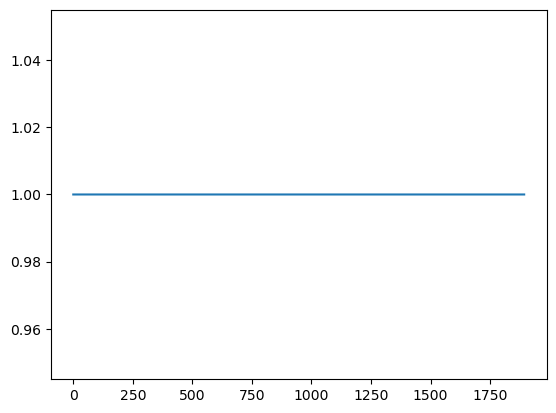

In [17]:
plt.plot(np.round(np.diff(df.frame_timestamp)[1:] / (1/190), 1))